### Importing Libraries

In [1]:
from PIL import Image, PngImagePlugin
import numpy as np
import matplotlib.pyplot as plt
import shamirc as sis
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision
from torchvision import transforms as T

### Defining functions

In [2]:
def get_model(classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, classes)
    return model

In [3]:
def predict(model, image_path, device, score_threshold=0.5):
    transform = T.Compose([T.ToTensor(), ])
    image = transform(Image.open(image_path).convert("RGB"))
    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])

    masks = prediction[0]['masks'].cpu().numpy()  # (N, 1, H, W)
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    #print(scores, "\n", masks)

    if len(boxes) == 0:
        print("No predictions were made for this image.")
        return None

    plt.imshow(Image.open(image_path).convert("RGB"))
    save_box = []
    for i in range(len(boxes)):
        if scores[i] > score_threshold:
            mask = masks[i, 0]
            plt.contour(mask, colors='r', linewidths=2)  # Mask contour

            box = boxes[i]
            print(f"Box = {box}")
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='blue', fill=False, linewidth=2))  # Bounding box
            plt.text(box[0], box[1] - 10, f'{i+1}', color='yellow', fontsize=8, bbox=dict(facecolor='blue', alpha=0.5))  # Text label
            save_box.append(box)
    print(f"Number of Boxes Predicted = {len(save_box)}")
    plt.show()
    return save_box

### Share Generation (Encryption)

In [4]:
model = get_model(classes=2)
model.load_state_dict(torch.load("Number_Plate_Model.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

#### Enter Image and Encryption details and get the Detected Number Plate

Box = [172.46997 347.33398 222.54878 368.1833 ]
Number of Boxes Predicted = 1


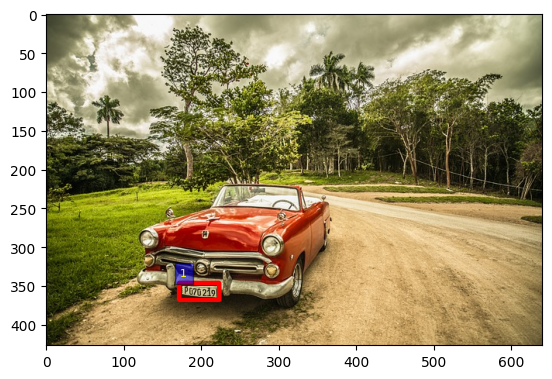

In [5]:
file_name=input("Enter name of the image file with extension and path:")
n = int(input("Enter no of shares(n): "))
k =int(input("Enter minimum shares to reveal secret(k): "))
img=Image.open(file_name)
boxes = predict(model, file_name, device=torch.device('cpu'))

Displaying the Detected Region (Secret)

In [6]:
xmin, ymin, xmax, ymax = map(int, boxes[0])
cropped_image = img.crop((xmin, ymin, xmax, ymax))
cropped_image

Size of Cropped Region

In [7]:
cropped_image.size

(50, 21)

#### Encrypting only cropped Region of Image

In [8]:
encrypted_img = sis.encrypt(n, k, cropped_image)

In [9]:
print(encrypted_img)

[[[[ 47   3 250]
   [ 41  78  62]
   [142 193 166]
   ...
   [ 76 152 253]
   [206  77  58]
   [204 162   9]]

  [[229 253 206]
   [ 78 177  92]
   [ 56 244 187]
   ...
   [150 192 161]
   [136  94 152]
   [119  34 151]]

  [[ 47  24  24]
   [250 201 171]
   [ 84  63  24]
   ...
   [ 43 212  77]
   [139 105  98]
   [ 10 117 214]]

  ...

  [[108  65  83]
   [225 249  42]
   [  2  61  71]
   ...
   [ 73  29 181]
   [129  38  21]
   [243  67 157]]

  [[237  16  44]
   [147 205  65]
   [191  12  97]
   ...
   [171  52 213]
   [216 145 254]
   [240 189 178]]

  [[ 80 232 215]
   [  3 239  23]
   [ 88 119 213]
   ...
   [165 253  11]
   [ 76   3 217]
   [156 104 143]]]


 [[[177 253 127]
   [187  97 236]
   [210 112 211]
   ...
   [113 223 108]
   [109 127 240]
   [ 95 158 145]]

  [[ 35  84  54]
   [ 59 249  92]
   [252 110 145]
   ...
   [ 99  68 247]
   [ 89 225 138]
   [182 157 152]]

  [[185 192  90]
   [123   7 153]
   [175  91 110]
   ...
   [  4 108  52]
   [102 134 123]
   [ 87 178

In [10]:
np.shape(encrypted_img)

(3, 21, 50, 3)

#### Replace the Predicted Region with Encrypted Shares and save the files

In [11]:
def replace_with_encryption(img, encrypted_img, n : int, xmin, ymin, xmax, ymax, output_dir, metadata):
    img_temp = img.copy()
    bbox = [xmin, ymin, xmax, ymax]
    bbox_string = str(bbox)
    metadata.add_text("bounding_boxes", bbox_string)
    for i in range(n):
        region = Image.fromarray(encrypted_img[i].astype('uint8'))
        Image.Image.paste(img_temp, region, (xmin, ymin))
        img_temp.save(output_dir+str(i+1)+".png", pnginfo=metadata)

Calling the function and Saving Files

In [12]:
metadata = PngImagePlugin.PngInfo()
replace_with_encryption(img, encrypted_img, n, xmin, ymin, xmax, ymax, "Shares\share", metadata)
print("Shares Generation")

Shares Generation


Displaying a secret region

In [13]:
img_temp1 = img.copy()
region = Image.fromarray(encrypted_img[0].astype('uint8'))
region

Displaying a Share

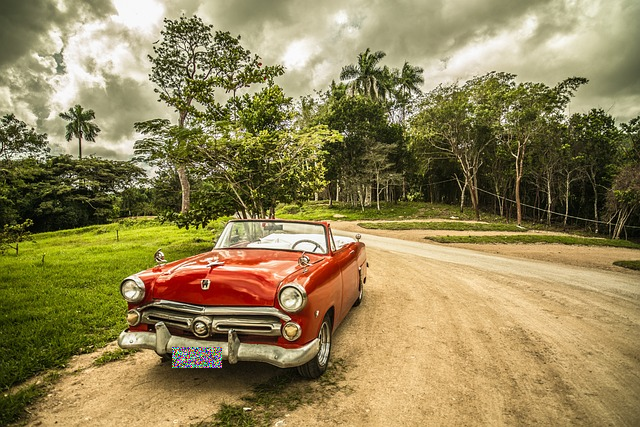

In [14]:
Image.Image.paste(img_temp1, region, (xmin, ymin))
img_temp1

### Recovery of Secret (Decryption)

Extracting Bounding Box from Image Metadata

In [15]:
def retrieve_bbox(image):
    metadata = image.info 
    # Retrieve bounding boxes from metadata
    if "bounding_boxes" in metadata:
        bounding_boxes = eval(metadata["bounding_boxes"])  # Convert string back to list
        return bounding_boxes
    else:
        return None

Information for Reconstructing Secret

In [16]:
n=int(input("Enter number of shares:"))
print("Enter the share numbers(1-n):")
shareno= [0 for _ in range (n)]
for i in range(n):
    shareno[i]=int(input())
share1 = Image.open(r"Shares\share"+str(shareno[0])+".png")
bbox = retrieve_bbox(share1) #can be done from any share
print (f"Share numbers: {shareno}")

Enter the share numbers(1-n):
Share numbers: [1, 2]


#### 1st Share (used for Extracting the non-secret region of the Image )

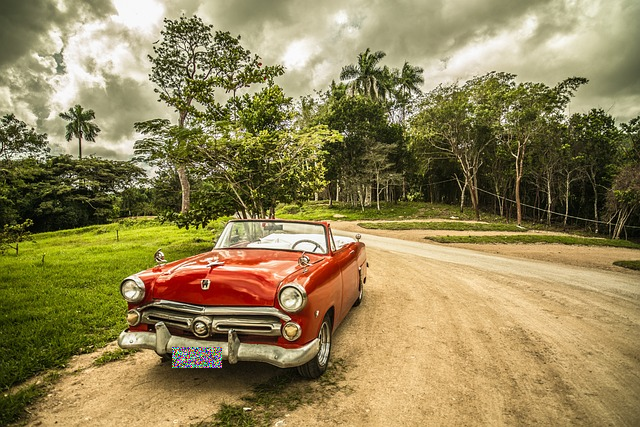

In [17]:
share1

#### Reconstructing Secret Region

In [18]:
secret_region = sis.decrypt(n, shareno, tuple(bbox))
print("Secret Generated!")
secret_img=Image.fromarray(secret_region.astype('uint8'))
secret_img

Secret Generated!


#### Pasting the secret region on the share

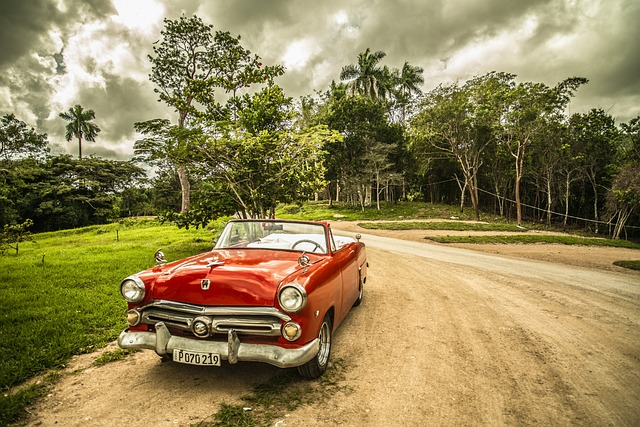

In [19]:
Image.Image.paste(share1, secret_img, (bbox[0], bbox[1]))
share1

In [20]:
share1.save('Secret.png')

### Checking Whether the Original Image and Reconstructed Image are equal

In [21]:
img1 = Image.open("test.jpg").convert('RGB') #original image
img2 = Image.open("Secret.png").convert('RGB') #secret image
arr1=img1.load()
arr2=img2.load()
w,h=img1.size
arr1 = np.array([[arr1[x, y] for y in range(h)] for x in range(w)])
arr2 = np.array([[arr2[x, y] for y in range(h)] for x in range(w)])
r = np.array_equal(arr1, arr2)
if (r==True): print("Images are Exactly same ")
else: print("Images are different")

Images are Exactly same 


#### So, it's proved that Original and Reconstructed Images are same

## Impainting

In [26]:
import cv2 as cv

In [30]:
img = cv.imread('test.jpg')
img

array([[[ 44,  65,  62],
        [ 44,  65,  62],
        [ 45,  66,  63],
        ...,
        [136, 174, 168],
        [137, 173, 167],
        [136, 172, 166]],

       [[ 44,  65,  62],
        [ 44,  65,  62],
        [ 45,  66,  63],
        ...,
        [138, 176, 170],
        [136, 172, 166],
        [133, 169, 163]],

       [[ 45,  66,  63],
        [ 45,  66,  63],
        [ 45,  66,  63],
        ...,
        [134, 172, 166],
        [132, 168, 162],
        [130, 166, 160]],

       ...,

       [[  7,  29,  27],
        [  8,  30,  28],
        [ 15,  36,  34],
        ...,
        [ 50,  85,  99],
        [ 54,  89, 103],
        [ 54,  89, 103]],

       [[ 16,  29,  31],
        [ 19,  34,  36],
        [ 25,  40,  42],
        ...,
        [ 51,  86, 100],
        [ 52,  87, 101],
        [ 51,  86, 100]],

       [[ 12,  23,  27],
        [ 11,  23,  27],
        [ 23,  35,  39],
        ...,
        [ 52,  87, 101],
        [ 51,  86, 100],
        [ 47,  82,  96]]

In [39]:
mask = np.zeros(img.shape[:2], dtype=np.uint8)
cv.rectangle(mask, (xmin, ymin), (xmax, ymax), 255, thickness=-1)
masked_img = cv.bitwise_and(img, img, mask=mask)
gray_masked_img = cv.cvtColor(masked_img, cv.COLOR_BGR2GRAY)
gray_masked_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [41]:
dst = cv.inpaint(img,gray_masked_img,3,cv.INPAINT_TELEA)
dst

array([[[ 44,  65,  62],
        [ 44,  65,  62],
        [ 45,  66,  63],
        ...,
        [136, 174, 168],
        [137, 173, 167],
        [136, 172, 166]],

       [[ 44,  65,  62],
        [ 44,  65,  62],
        [ 45,  66,  63],
        ...,
        [138, 176, 170],
        [136, 172, 166],
        [133, 169, 163]],

       [[ 45,  66,  63],
        [ 45,  66,  63],
        [ 45,  66,  63],
        ...,
        [134, 172, 166],
        [132, 168, 162],
        [130, 166, 160]],

       ...,

       [[  7,  29,  27],
        [  8,  30,  28],
        [ 15,  36,  34],
        ...,
        [ 50,  85,  99],
        [ 54,  89, 103],
        [ 54,  89, 103]],

       [[ 16,  29,  31],
        [ 19,  34,  36],
        [ 25,  40,  42],
        ...,
        [ 51,  86, 100],
        [ 52,  87, 101],
        [ 51,  86, 100]],

       [[ 12,  23,  27],
        [ 11,  23,  27],
        [ 23,  35,  39],
        ...,
        [ 52,  87, 101],
        [ 51,  86, 100],
        [ 47,  82,  96]]

In [47]:
cv.imwrite('masked_test1.jpg', dst)

True

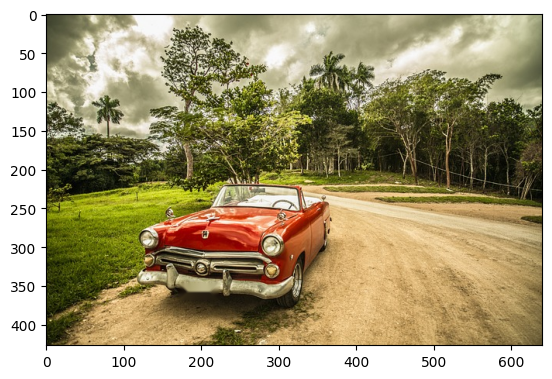

In [46]:
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

In [23]:
!git clone https://github.com/sujaykhandekar/Automated-objects-removal-inpainter.git

Cloning into 'Automated-objects-removal-inpainter'...


In [24]:
!cd Automated-objects-removal-inpainter
pip install -r requirements.txt

^C


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
